In [1]:
%matplotlib inline

In [2]:
# imports
from __future__ import print_function,absolute_import,division,unicode_literals
import numpy as np
import glob,os,sys,copy,imp 
from scipy import stats as scistats
import matplotlib as mpl
mpl.rcParams['font.family']='stixgeneral'
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.table import QTable,Table
from astropy.io import ascii,fits
from astropy import units as u
from astropy import constants as const
from astropy.coordinates import SkyCoord
from linetools.spectralline import AbsLine
import linetools.utils as ltu
from xastropy.igm.abs_sys import abssys_utils as abssys
from xastropy import spec as xpsec
from xastropy.plotting import utils as xputils
from xastropy.xutils import xdebug as xdb
from xastropy.obs import radec as xor
from xastropy.atomic import ionization as xai
from xastropy.xutils import fits as xxf
sys.path.append(os.path.abspath("../../../../py"))
from enigma.qpq import utils as qpqutils
from enigma.qpq import spec as qpqs
from enigma.qpq import stacks as qpqk
sys.path.append(os.path.abspath("../Bootstrap/py"))
import qpq9_boot as qpq9b
sys.path.append(os.path.abspath("./py"))
import qpq9_stacks as qpq9k

/Users/lwymarie/anaconda/lib/python2.7/site-packages/astroquery/sdss/__init__.py:28: UserWarning: Experimental: SDSS has not yet been refactored to have its API match the rest of astroquery (but it's nearly there).
  warnings.warn("Experimental: SDSS has not yet been refactored to have its API "


## Load stack_tup

In [192]:
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1334.5323*u.AA,S2N_cut=5.5/u.AA,zfg_mnx=(1.6,9999),plot_indiv=False)
# Mask
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,dd in enumerate(all_dict):
    if dd is None:
        continue
    if 'J1508+3635' in dd['qpq']['NAME']: #DLA not excluded by forest cut, should be excluded now
        idx_mask.append(ii)
for idx in idx_mask:
    stck_mskN[idx,:] = 0.

Reading /Users/lwymarie/python/enigma/enigma/data/qpq/qpq9_final.fits
4.5030178527 1 / Angstrom
No spectrum found for BOSSJ0008-0039 and wvobs=3920.97 Angstrom!
3.96814209033 1 / Angstrom
No spectrum found for BOSSJ0042+1350 and wvobs=3704.79 Angstrom!
81.1223225091 1 / Angstrom
44.1513656402 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/GMOS_redux//./SDSSJ034139.19-000012.7_b1200_F.fits.gz for SDSSJ0341-0000
S/N 81.1223225091 1 / Angstrom
91.8691590217 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ080048.74+354231.3_b1200_F.fits.gz for APOJ0800+3542
S/N 91.8691590217 1 / Angstrom
6.82627542183 1 / Angstrom
Using spec-7328-56715-0428.fits.gz for BOSSJ0809+4539
S/N 6.82627542183 1 / Angstrom
No spectrum found for BOSSJ0826+4708 and wvobs=3734.97 Angstrom!
7.18768185783 1 / Angstrom
30.4325951329 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ082844.87+454518.2_b1200_F.fits.gz for SDSSJ0828+4545
S/N 30.4325951329 1 / Angstrom
30.2325

In [39]:
print(np.sum(stck_mskN,0))
sv_zfg = []
sv_Rperp = []
for ii,dd in enumerate(all_dict):
    if dd is None:
        continue
    if np.sum(stck_mskN[ii,:]) == 0:
        continue
    sv_zfg.append(dd['qpq']['Z_FG'])
    sv_Rperp.append(dd['qpq']['R_PHYS'])
np.median(sv_zfg),np.median(sv_Rperp)

[ 34.  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.
  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.
  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.
  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.
  34.]


(2.0323045180781749, 179.56190792887546)

## Stack and Plot

### Mean

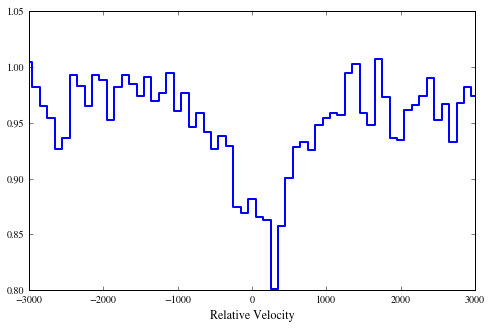

In [193]:
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

### Median

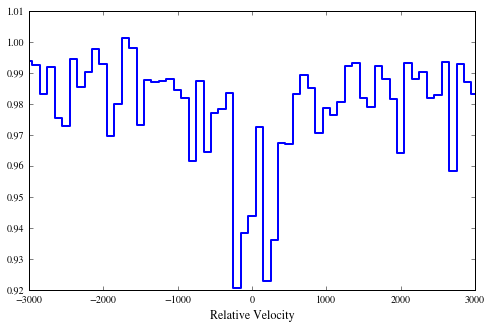

In [194]:
fin_velo, fin_flx_med, all_dict = qpqk.stack_med(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx_med, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

### Write 

In [195]:
from linetools.spectra.xspectrum1d import XSpectrum1D
outfil = 'Output/QPQ9_zIRMgII_1334_mean.fits'
relativistic_equiv = u.doppler_relativistic(1334.5323*u.AA)
fin_wave = fin_velo.to(u.AA,equivalencies=relativistic_equiv)
xspec1d = XSpectrum1D.from_tuple((fin_wave, u.Quantity(fin_flx)))
xspec1d.write_to_fits(outfil,clobber=True)
outfil = 'Output/QPQ9_zIRMgII_1334_med.fits'
xspec1d = XSpectrum1D.from_tuple((fin_wave, u.Quantity(fin_flx_med)))
xspec1d.write_to_fits(outfil,clobber=True)

Wrote spectrum to Output/QPQ9_zIRMgII_1334_mean.fits
Wrote spectrum to Output/QPQ9_zIRMgII_1334_med.fits


## Bootstrap

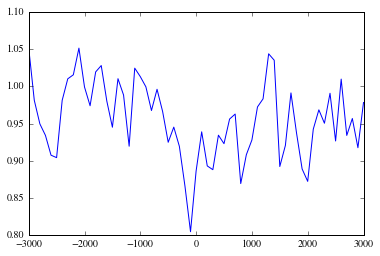

[ 0.0351712]
Model: CompoundModel269762
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Expression: [0] * [1]
Components: 
    [0]: <Const1D(amplitude=0.9663394196273172)>

    [1]: <GaussianAbsorption1D(amplitude=0.2, mean=205.0, stddev=355.0)>
Parameters:
     amplitude_0     amplitude_1       mean_1      stddev_1  
    -------------- --------------- ------------- ------------
    0.966339419627 0.0992670179163 -5.5722677207 311.73727881


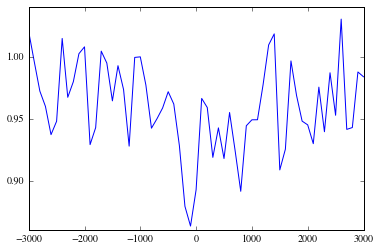

[ 0.02324277]
Model: CompoundModel269764
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Expression: [0] * [1]
Components: 
    [0]: <Const1D(amplitude=0.9709317002157039)>

    [1]: <GaussianAbsorption1D(amplitude=0.2, mean=205.0, stddev=355.0)>
Parameters:
     amplitude_0     amplitude_1       mean_1       stddev_1  
    -------------- --------------- ------------- -------------
    0.970931700216 0.0562491342242 154.777246796 543.597030561


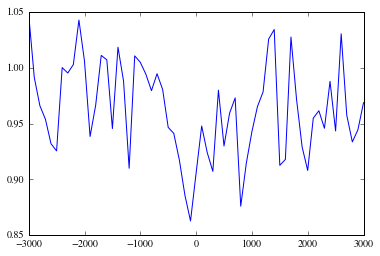

[ 0.02943439]
Model: CompoundModel269801
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Expression: [0] * [1]
Components: 
    [0]: <Const1D(amplitude=0.9729199246052254)>

    [1]: <GaussianAbsorption1D(amplitude=0.2, mean=205.0, stddev=355.0)>
Parameters:
     amplitude_0     amplitude_1       mean_1        stddev_1  
    -------------- --------------- -------------- -------------
    0.972919924605 0.0863740679384 -78.5026140652 255.313808705


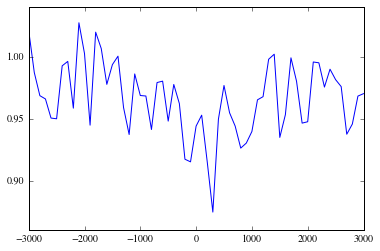

[ 0.01861402]
Model: CompoundModel269806
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Expression: [0] * [1]
Components: 
    [0]: <Const1D(amplitude=0.9781858366648227)>

    [1]: <GaussianAbsorption1D(amplitude=0.2, mean=205.0, stddev=355.0)>
Parameters:
     amplitude_0     amplitude_1       mean_1       stddev_1  
    -------------- --------------- ------------- -------------
    0.978185836665 0.0501499566385 255.152718444 590.163349956


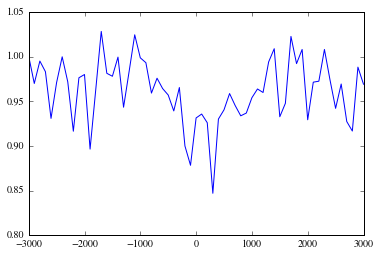

[ 0.02363274]
Model: CompoundModel269830
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Expression: [0] * [1]
Components: 
    [0]: <Const1D(amplitude=0.971140978735417)>

    [1]: <GaussianAbsorption1D(amplitude=0.2, mean=205.0, stddev=355.0)>
Parameters:
     amplitude_0     amplitude_1       mean_1       stddev_1  
    -------------- --------------- ------------- -------------
    0.971140978735 0.0675736592445 164.132673522 402.706799532


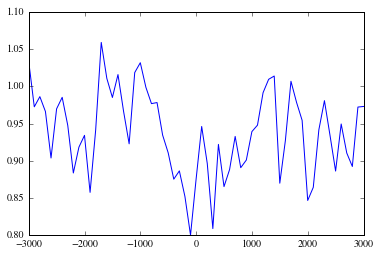

[ 0.0389784]
Model: CompoundModel269855
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Expression: [0] * [1]
Components: 
    [0]: <Const1D(amplitude=0.9491661672051803)>

    [1]: <GaussianAbsorption1D(amplitude=0.2, mean=205.0, stddev=355.0)>
Parameters:
     amplitude_0     amplitude_1       mean_1       stddev_1  
    -------------- --------------- ------------- -------------
    0.949166167205 0.0955227267994 105.991211371 414.929471383


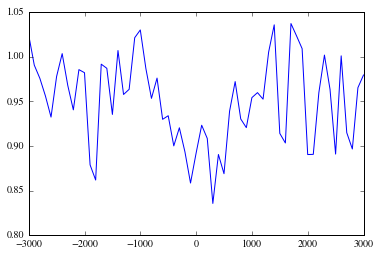

[ 0.03583657]
Model: CompoundModel269911
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Expression: [0] * [1]
Components: 
    [0]: <Const1D(amplitude=0.9609070041291027)>

    [1]: <GaussianAbsorption1D(amplitude=0.2, mean=205.0, stddev=355.0)>
Parameters:
     amplitude_0     amplitude_1       mean_1       stddev_1  
    -------------- --------------- ------------- -------------
    0.960907004129 0.0880088652357 127.208662025 399.883653351


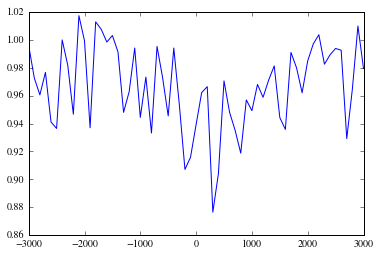

[ 0.01844985]
Model: CompoundModel269968
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Expression: [0] * [1]
Components: 
    [0]: <Const1D(amplitude=0.9794283655567168)>

    [1]: <GaussianAbsorption1D(amplitude=0.2, mean=205.0, stddev=355.0)>
Parameters:
     amplitude_0     amplitude_1       mean_1       stddev_1  
    -------------- --------------- ------------- -------------
    0.979428365557 0.0501368440234 317.997246997 647.060450518


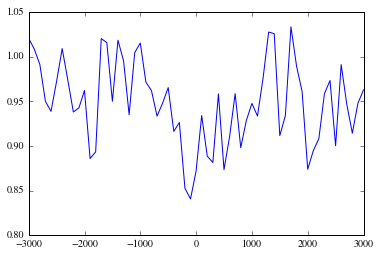

[ 0.0329894]
Model: CompoundModel270067
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Expression: [0] * [1]
Components: 
    [0]: <Const1D(amplitude=0.9592585245527611)>

    [1]: <GaussianAbsorption1D(amplitude=0.2, mean=205.0, stddev=355.0)>
Parameters:
     amplitude_0    amplitude_1      mean_1       stddev_1  
    -------------- -------------- ------------ -------------
    0.959258524553 0.083435193745 78.552974093 400.476920367


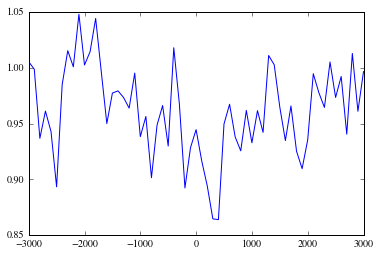

[ 0.02642317]
Model: CompoundModel270089
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Expression: [0] * [1]
Components: 
    [0]: <Const1D(amplitude=0.9767138030545974)>

    [1]: <GaussianAbsorption1D(amplitude=0.2, mean=205.0, stddev=355.0)>
Parameters:
     amplitude_0     amplitude_1       mean_1       stddev_1  
    -------------- --------------- ------------- -------------
    0.976713803055 0.0704594263038 244.220039875 506.660338075


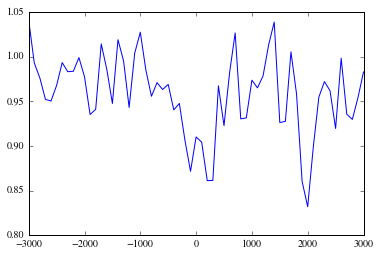

[ 0.03292607]
Model: CompoundModel270092
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Expression: [0] * [1]
Components: 
    [0]: <Const1D(amplitude=0.9621197356363905)>

    [1]: <GaussianAbsorption1D(amplitude=0.2, mean=205.0, stddev=355.0)>
Parameters:
     amplitude_0     amplitude_1      mean_1      stddev_1  
    -------------- --------------- ------------ ------------
    0.962119735636 0.0903496803176 82.293919592 238.33343851


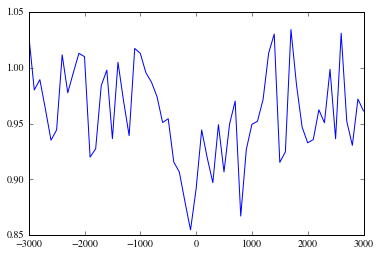

[ 0.02674591]
Model: CompoundModel270165
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Expression: [0] * [1]
Components: 
    [0]: <Const1D(amplitude=0.9711298417295152)>

    [1]: <GaussianAbsorption1D(amplitude=0.2, mean=205.0, stddev=355.0)>
Parameters:
     amplitude_0    amplitude_1       mean_1       stddev_1  
    ------------- --------------- ------------- -------------
    0.97112984173 0.0775309522508 78.4372624469 443.382882259


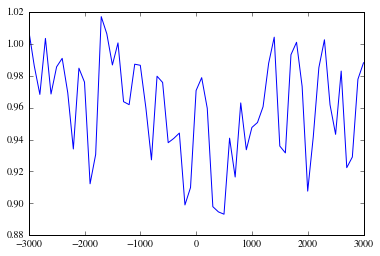

[ 0.0226511]
Model: CompoundModel270230
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Expression: [0] * [1]
Components: 
    [0]: <Const1D(amplitude=0.9708952253046335)>

    [1]: <GaussianAbsorption1D(amplitude=0.2, mean=205.0, stddev=355.0)>
Parameters:
     amplitude_0     amplitude_1       mean_1       stddev_1  
    -------------- --------------- ------------- -------------
    0.970895225305 0.0495768839452 308.383293833 555.783264436


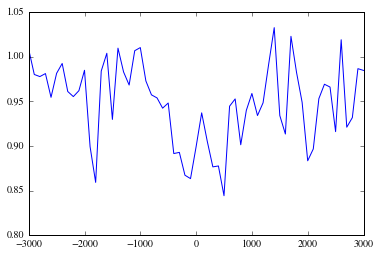

[ 0.03059145]
Model: CompoundModel270250
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Expression: [0] * [1]
Components: 
    [0]: <Const1D(amplitude=0.961232087578122)>

    [1]: <GaussianAbsorption1D(amplitude=0.2, mean=205.0, stddev=355.0)>
Parameters:
     amplitude_0     amplitude_1       mean_1       stddev_1  
    -------------- --------------- ------------- -------------
    0.961232087578 0.0854514199361 129.423169308 450.427300096


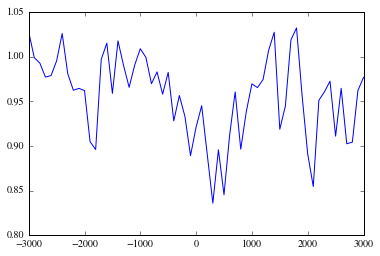

[ 0.03348345]
Model: CompoundModel270283
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Expression: [0] * [1]
Components: 
    [0]: <Const1D(amplitude=0.9647732239126334)>

    [1]: <GaussianAbsorption1D(amplitude=0.2, mean=205.0, stddev=355.0)>
Parameters:
     amplitude_0     amplitude_1       mean_1       stddev_1  
    -------------- --------------- ------------- -------------
    0.964773223913 0.0950595421832 337.118366319 317.488043075


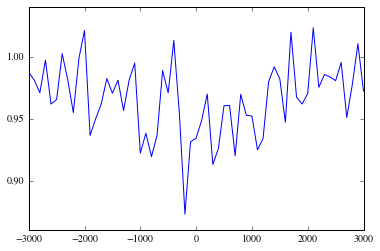

[ 0.0155609]
Model: CompoundModel270330
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Expression: [0] * [1]
Components: 
    [0]: <Const1D(amplitude=0.9793131047002582)>

    [1]: <GaussianAbsorption1D(amplitude=0.2, mean=205.0, stddev=355.0)>
Parameters:
    amplitude_0    amplitude_1       mean_1       stddev_1  
    ------------ --------------- ------------- -------------
    0.9793131047 0.0415769482531 92.3339202007 853.275380063


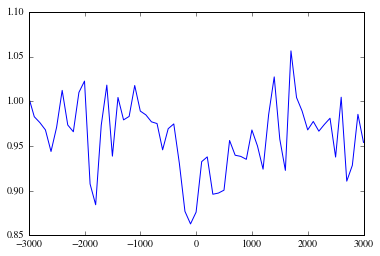

[ 0.02762774]
Model: CompoundModel270331
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Expression: [0] * [1]
Components: 
    [0]: <Const1D(amplitude=0.9734839007877151)>

    [1]: <GaussianAbsorption1D(amplitude=0.2, mean=205.0, stddev=355.0)>
Parameters:
     amplitude_0     amplitude_1       mean_1      stddev_1  
    -------------- --------------- ------------- ------------
    0.973483900788 0.0814420298451 148.525246751 424.34128849


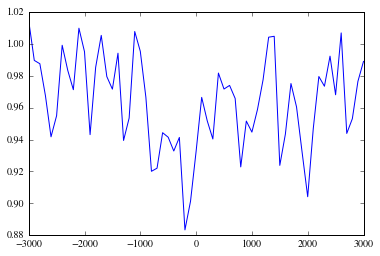

[ 0.01960752]
Model: CompoundModel270353
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Expression: [0] * [1]
Components: 
    [0]: <Const1D(amplitude=0.9725289952572256)>

    [1]: <GaussianAbsorption1D(amplitude=0.2, mean=205.0, stddev=355.0)>
Parameters:
     amplitude_0     amplitude_1       mean_1        stddev_1  
    -------------- --------------- -------------- -------------
    0.972528995257 0.0582394168256 -267.653504201 346.267265506


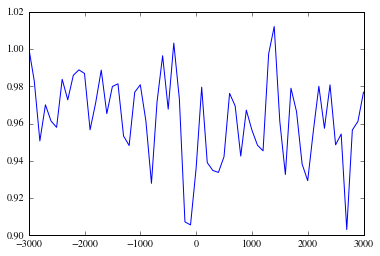

[ 0.01588194]
Model: CompoundModel270415
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Expression: [0] * [1]
Components: 
    [0]: <Const1D(amplitude=0.9670233557260175)>

    [1]: <GaussianAbsorption1D(amplitude=0.2, mean=205.0, stddev=355.0)>
Parameters:
     amplitude_0     amplitude_1       mean_1       stddev_1  
    -------------- --------------- ------------- -------------
    0.967023355726 0.0338658789278 101.667009664 290.149954393


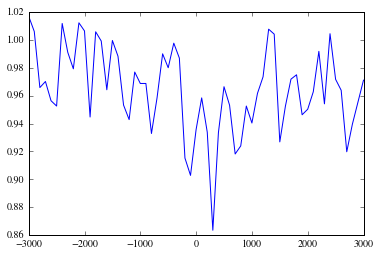

[ 0.01929877]
Model: CompoundModel270430
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Expression: [0] * [1]
Components: 
    [0]: <Const1D(amplitude=0.9744455917620752)>

    [1]: <GaussianAbsorption1D(amplitude=0.2, mean=205.0, stddev=355.0)>
Parameters:
     amplitude_0     amplitude_1       mean_1       stddev_1  
    -------------- --------------- ------------- -------------
    0.974445591762 0.0545752374634 329.123069611 429.520510519


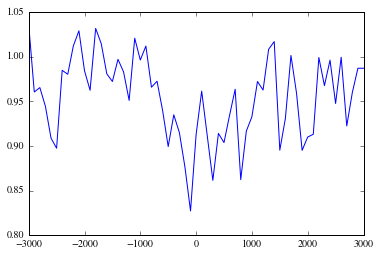

[ 0.03011446]
Model: CompoundModel270434
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Expression: [0] * [1]
Components: 
    [0]: <Const1D(amplitude=0.9690029680830421)>

    [1]: <GaussianAbsorption1D(amplitude=0.2, mean=205.0, stddev=355.0)>
Parameters:
     amplitude_0     amplitude_1      mean_1       stddev_1  
    -------------- --------------- ------------ -------------
    0.969002968083 0.0813530364172 151.91916655 501.797447058


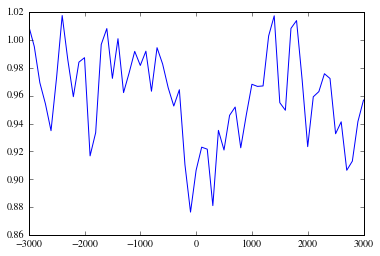

[ 0.02328069]
Model: CompoundModel270446
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Expression: [0] * [1]
Components: 
    [0]: <Const1D(amplitude=0.9676359938296478)>

    [1]: <GaussianAbsorption1D(amplitude=0.2, mean=205.0, stddev=355.0)>
Parameters:
     amplitude_0    amplitude_1       mean_1       stddev_1  
    ------------- --------------- ------------- -------------
    0.96763599383 0.0690001102318 159.643514844 343.360793747


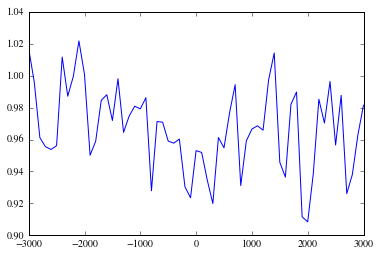

[ 0.02176559]
Model: CompoundModel270451
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Expression: [0] * [1]
Components: 
    [0]: <Const1D(amplitude=0.9718719423985412)>

    [1]: <GaussianAbsorption1D(amplitude=0.2, mean=205.0, stddev=355.0)>
Parameters:
     amplitude_0     amplitude_1       mean_1      stddev_1  
    -------------- --------------- ------------- ------------
    0.971871942399 0.0360657197435 27.1978006002 364.18698988


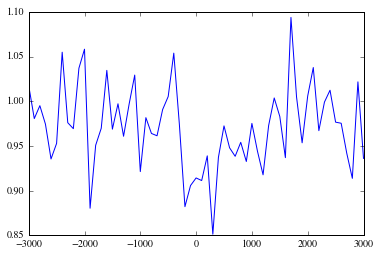

[ 0.03255052]
Model: CompoundModel270483
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Expression: [0] * [1]
Components: 
    [0]: <Const1D(amplitude=0.9857285698443962)>

    [1]: <GaussianAbsorption1D(amplitude=0.2, mean=205.0, stddev=355.0)>
Parameters:
     amplitude_0     amplitude_1       mean_1       stddev_1  
    -------------- --------------- ------------- -------------
    0.985728569844 0.0751415476522 271.946376187 435.467280149


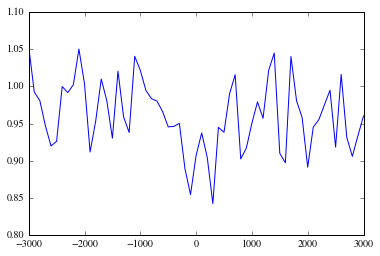

[ 0.03412789]
Model: CompoundModel270548
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Expression: [0] * [1]
Components: 
    [0]: <Const1D(amplitude=0.9685563140381191)>

    [1]: <GaussianAbsorption1D(amplitude=0.2, mean=205.0, stddev=355.0)>
Parameters:
     amplitude_0     amplitude_1       mean_1       stddev_1  
    -------------- --------------- ------------- -------------
    0.968556314038 0.0847921915154 42.9451948657 292.309116562


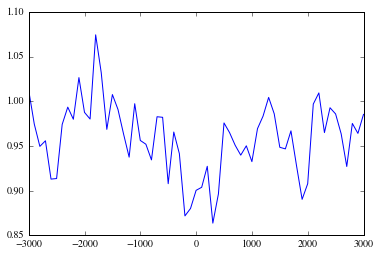

[ 0.02807916]
Model: CompoundModel270568
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Expression: [0] * [1]
Components: 
    [0]: <Const1D(amplitude=0.9726506578897135)>

    [1]: <GaussianAbsorption1D(amplitude=0.2, mean=205.0, stddev=355.0)>
Parameters:
     amplitude_0    amplitude_1       mean_1       stddev_1  
    ------------- --------------- ------------- -------------
    0.97265065789 0.0838069777608 51.7320577808 380.796251597


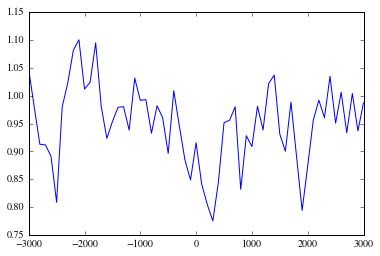

[ 0.05239792]
Model: CompoundModel270690
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Expression: [0] * [1]
Components: 
    [0]: <Const1D(amplitude=0.9670409281306277)>

    [1]: <GaussianAbsorption1D(amplitude=0.2, mean=205.0, stddev=355.0)>
Parameters:
     amplitude_0    amplitude_1       mean_1       stddev_1  
    -------------- -------------- ------------- -------------
    0.967040928131 0.157080829253 190.220037889 255.627714714
Equivalent width skewness: Mean=0.407876, Median=0.396264, std=0.253149 for Ntrials=1000
Centroid: Mean = 156.559, scatter=117.587
Dispersion and scatter of it:  371.143132185 85.8540419402
max and min centroid:  459.1686948 -288.031394527
Wrote ../Bootstrap/Output/IRMgII_1334_mean.fits


In [208]:
#Mean 
reload(qpq9b)
qpq9b.boot_trans(wrest=1334.5323*u.AA,outfil='../Bootstrap/Output/IRMgII_1334_mean.fits',stack_tup0=stack_tup,nboot=1000)

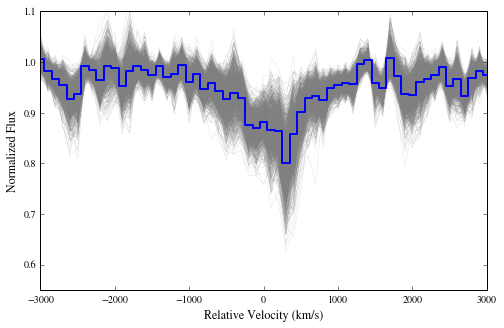

In [209]:
# plot trials
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
hdulist = fits.open('../Bootstrap/Output/IRMgII_1334_mean.fits')
boot_img = hdulist[1].data
for bb in np.arange(np.shape(boot_img)[0]):
    plt.plot(fin_velo,boot_img[bb,:],drawstyle='step-mid',linewidth=0.1,color='gray')
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.axis([-3000,3000,0.55,1.1])
plt.xlabel('Relative Velocity (km/s)', size=12.)
plt.ylabel('Normalized Flux', size=12.)
plt.show()

0.103

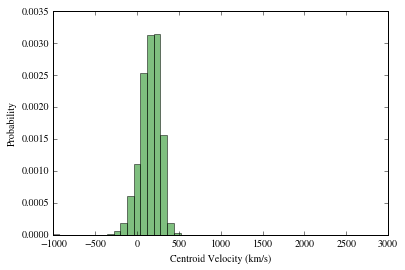

In [210]:
# Plot centroids
tau_cen = hdulist[3].data
n, bins, patches = plt.hist(tau_cen, 50, normed=1, facecolor='green', alpha=0.5,range=(-1000,3000))
plt.xlabel('Centroid Velocity (km/s)')
plt.ylabel('Probability')
len(np.where(tau_cen < 0)[0])/len(tau_cen)

In [68]:
#Median
qpq9b.boot_trans(wrest=1334.5323*u.AA,outfil='../Bootstrap/Output/IRMgII_1334_med.fits',stack_tup0=stack_tup,median=True)

Equivalent width skewness: Mean=0.175286, Median=0.191927, std=0.322454 for Ntrials=10000
Centroid: Mean = 53.3799, scatter=144.989
Dispersion and scatter of it:  294.745987721 166.990231122
Wrote ../Bootstrap/Output/IRMgII_1334_med.fits


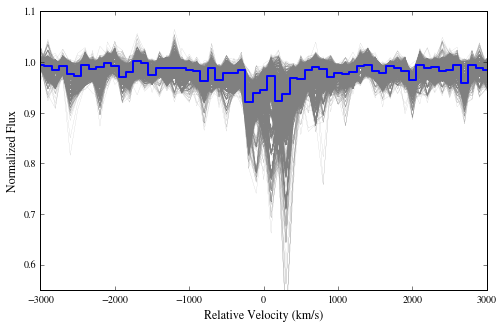

In [69]:
# plot trials
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_med(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
hdulist = fits.open('../Bootstrap/Output/IRMgII_1334_med.fits')
boot_img = hdulist[1].data
for bb in np.arange(np.shape(boot_img)[0]):
    plt.plot(fin_velo,boot_img[bb,:],drawstyle='step-mid',linewidth=0.1,color='gray')
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.axis([-3000,3000,0.55,1.1])
plt.xlabel('Relative Velocity (km/s)', size=12.)
plt.ylabel('Normalized Flux', size=12.)
plt.show()

# [OIII] only

Reading /Users/lwymarie/python/enigma/enigma/data/qpq/qpq9_final.fits
91.8691590217 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ080048.74+354231.3_b1200_F.fits.gz for APOJ0800+3542
S/N 91.8691590217 1 / Angstrom


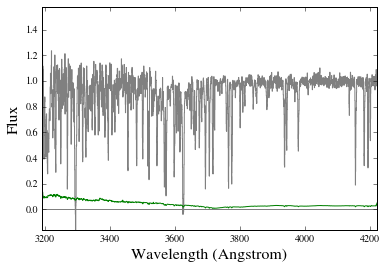

14.3637472477 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/BOSS/v5_5_0/SDSSJ084159.26+392140.0.fits for BOSSJ0841+3921
S/N 14.3637472477 1 / Angstrom


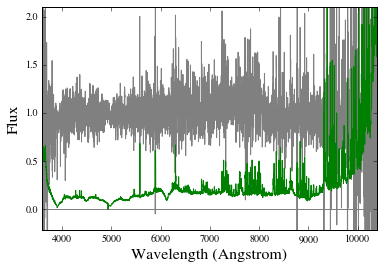

98.9433999318 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/MAGE_redux//./SDSSJ085357.49-001106.1_F.fits.gz for BOSSJ0853-0011
S/N 98.9433999318 1 / Angstrom


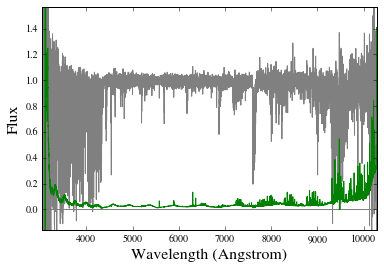

63.9766522587 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/MAGE_redux//./SDSSJ093225.60+092500.2_F.fits.gz for APOJ0932+0925
S/N 63.9766522587 1 / Angstrom


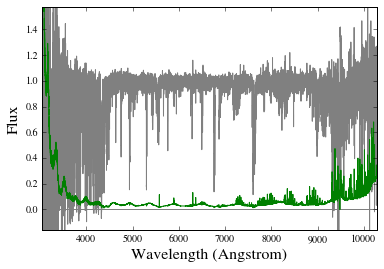

47.8324556688 1 / Angstrom
14.4231604961 1 / Angstrom
56.6214028343 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/ESI_redux//./SDSSJ103900.01+502652.8_F.fits.gz for BOSSJ1039+5026
S/N 56.6214028343 1 / Angstrom


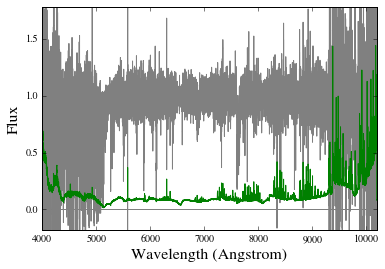

68.393253611 1 / Angstrom
143.628373235 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/ESI_redux//./SDSSJ114436.66+095904.9_F.fits.gz for BOSSJ1144+0959
S/N 143.628373235 1 / Angstrom


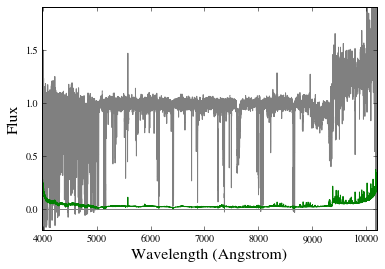

No continuum: /u/xavier/Dropbox//QSOPairs/data/GMOS_redux//./SDSSJ120416.69+022111.0_b1200_F.fits.gz
No continuum: /u/xavier/Dropbox//QSOPairs/data/HIRES_redux//./SDSSJ120416.69+022111.0_f.fits.gz
Using conti=1 for HIRES
142.871410019 1 / Angstrom
47.2201789204 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/HIRES_redux//./SDSSJ120416.69+022111.0_f.fits.gz for BOSSJ1204+0221
S/N 142.871410019 1 / Angstrom


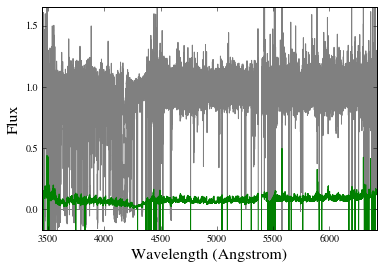

15.4016156076 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/SDSS//./SDSSJ121558.80+571555.4.fits.gz for BOSSJ1215+5715
S/N 15.4016156076 1 / Angstrom


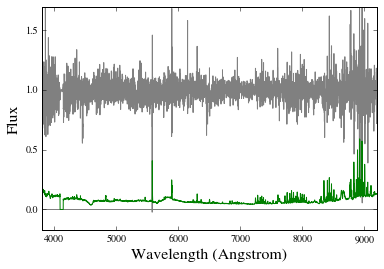

78.1873569683 1 / Angstrom
12.5385900365 1 / Angstrom
30.4123138554 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/GMOS_redux//./SDSSJ123141.73+002913.9_b600_F.fits.gz for BOSSJ1231+0029
S/N 78.1873569683 1 / Angstrom


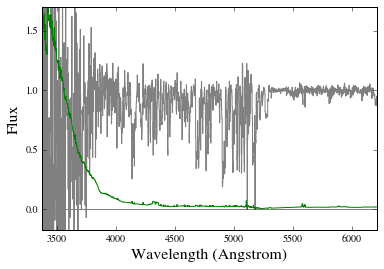

43.8456885446 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/MAGE_redux//./SDSSJ142054.92+160342.9_F.fits.gz for APOJ1420+1603
S/N 43.8456885446 1 / Angstrom


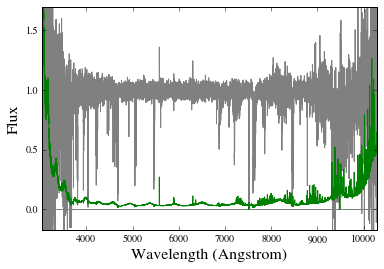

No continuum: /u/xavier/Dropbox//QSOPairs/data/GMOS_redux//./SDSSJ142758.74-012136.2_b1200_F.fits.gz
138.502983858 1 / Angstrom
105.739031052 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/MIKE_redux//./SDSSJ142758.74-012136.2_b_F.fits.gz for BOSSJ1427-0121
S/N 138.502983858 1 / Angstrom


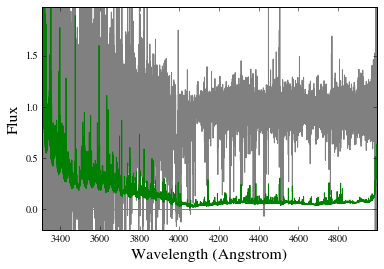

22.5711986597 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/BOSS/v5_4_45/SDSSJ143344.55+064111.9.fits for BOSSJ1433+0641
S/N 22.5711986597 1 / Angstrom


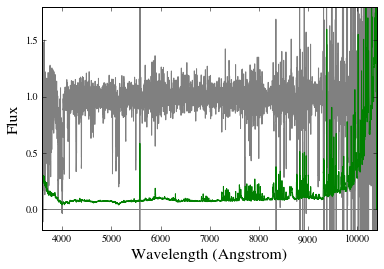

22.0937672202 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/MAGE_redux//./SDSSJ155325.89+192137.7_F.fits.gz for APOJ1553+1921
S/N 22.0937672202 1 / Angstrom


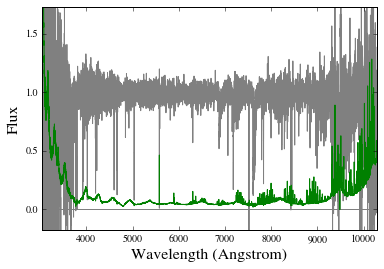

121.295573564 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/ESI_redux//./SDSSJ162737.25+460609.3_F.fits.gz for APOJ1627+4606
S/N 121.295573564 1 / Angstrom


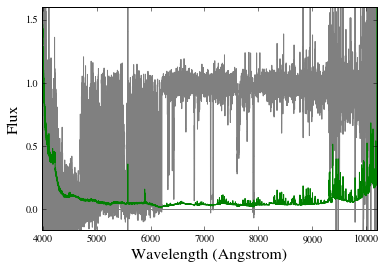

In [110]:
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1334.5323*u.AA,vsig_cut=50*u.km/u.s,S2N_cut=5.5/u.AA,zfg_mnx=(1.6,9999))
# Mask
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,dd in enumerate(all_dict):
    if dd is None:
        continue
    if 'J1508+3635' in dd['qpq']['NAME']: #DLA not excluded by forest cut, should be excluded now
        idx_mask.append(ii) 
for idx in idx_mask:
    stck_mskN[idx,:] = 0.

In [71]:
np.sum(stck_mskN,0)
sv_zfg = []
sv_Rperp = []
for ii,dd in enumerate(all_dict):
    if dd is None:
        continue
    if np.sum(stck_mskN[ii,:]) == 0:
        continue
    sv_zfg.append(dd['qpq']['Z_FG'])
    sv_Rperp.append(dd['qpq']['R_PHYS'])
np.median(sv_zfg),np.median(sv_Rperp)

(2.3475470474694551, 183.37371946093424)

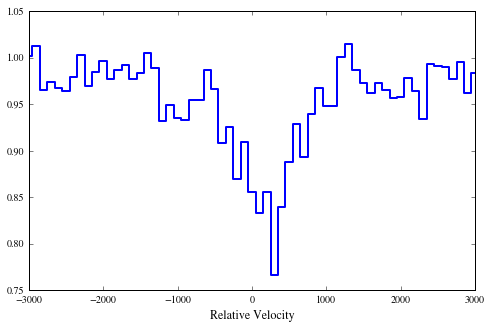

In [111]:
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

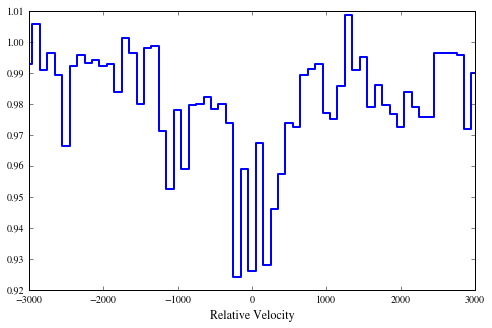

In [112]:
fin_velo, fin_flx_med, all_dict = qpqk.stack_med(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx_med, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

### Write

In [113]:
from linetools.spectra.xspectrum1d import XSpectrum1D
outfil = 'Output/QPQ9_zOIII_1334_mean.fits'
relativistic_equiv = u.doppler_relativistic(1334.5323*u.AA)
fin_wave = fin_velo.to(u.AA,equivalencies=relativistic_equiv)
xspec1d = XSpectrum1D.from_tuple((fin_wave, u.Quantity(fin_flx)))
xspec1d.write_to_fits(outfil,clobber=True)
outfil = 'Output/QPQ9_zOIII_1334_med.fits'
xspec1d = XSpectrum1D.from_tuple((fin_wave, u.Quantity(fin_flx_med)))
xspec1d.write_to_fits(outfil,clobber=True)

Wrote spectrum to Output/QPQ9_zOIII_1334_mean.fits
Wrote spectrum to Output/QPQ9_zOIII_1334_med.fits


## Bootstrap

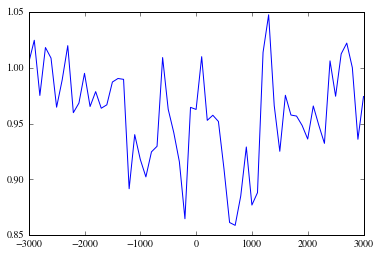

[ 0.0201089]
Model: CompoundModel264771
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Expression: [0] * [1]
Components: 
    [0]: <Const1D(amplitude=0.9769666710821521)>

    [1]: <GaussianAbsorption1D(amplitude=0.2, mean=205.0, stddev=355.0)>
Parameters:
     amplitude_0   amplitude_1     mean_1       stddev_1  
    -------------- ----------- ------------- -------------
    0.976966671082         0.0 284.541584177 560.299049166


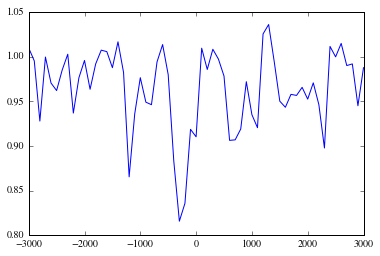

[ 0.02093923]
Model: CompoundModel264884
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Expression: [0] * [1]
Components: 
    [0]: <Const1D(amplitude=0.9766946075593722)>

    [1]: <GaussianAbsorption1D(amplitude=0.2, mean=205.0, stddev=355.0)>
Parameters:
     amplitude_0   amplitude_1     mean_1       stddev_1  
    -------------- ----------- ------------- -------------
    0.976694607559         0.0 111.960354061 552.814801843


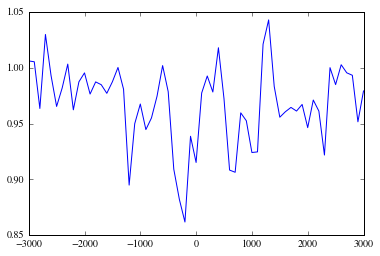

[ 0.0157008]
Model: CompoundModel264976
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Expression: [0] * [1]
Components: 
    [0]: <Const1D(amplitude=0.9796203352323097)>

    [1]: <GaussianAbsorption1D(amplitude=0.2, mean=205.0, stddev=355.0)>
Parameters:
     amplitude_0   amplitude_1    mean_1       stddev_1  
    -------------- ----------- ------------ -------------
    0.979620335232         0.0 142.58206228 510.853706164


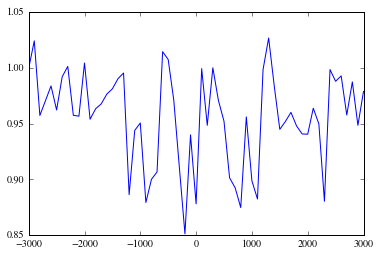

[ 0.01926835]
Model: CompoundModel265015
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Expression: [0] * [1]
Components: 
    [0]: <Const1D(amplitude=0.9692810686195598)>

    [1]: <GaussianAbsorption1D(amplitude=0.2, mean=205.0, stddev=355.0)>
Parameters:
     amplitude_0  amplitude_1     mean_1       stddev_1  
    ------------- ----------- ------------- -------------
    0.96928106862         0.0 202.987076164 503.359536388


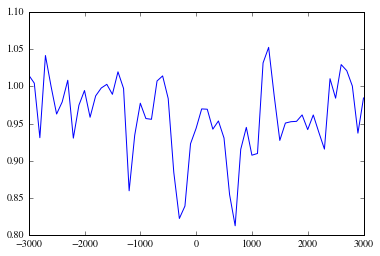

[ 0.02415942]
Model: CompoundModel265204
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Expression: [0] * [1]
Components: 
    [0]: <Const1D(amplitude=0.9780241442578178)>

    [1]: <GaussianAbsorption1D(amplitude=0.2, mean=205.0, stddev=355.0)>
Parameters:
     amplitude_0     amplitude_1       mean_1       stddev_1  
    -------------- --------------- ------------- -------------
    0.978024144258 0.0677148859781 282.358981147 742.479090692


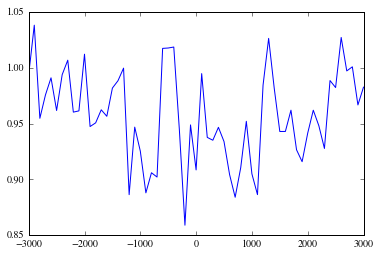

[ 0.02090424]
Model: CompoundModel265225
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Expression: [0] * [1]
Components: 
    [0]: <Const1D(amplitude=0.9715453193468204)>

    [1]: <GaussianAbsorption1D(amplitude=0.2, mean=205.0, stddev=355.0)>
Parameters:
     amplitude_0     amplitude_1       mean_1       stddev_1  
    -------------- --------------- ------------- -------------
    0.971545319347 0.0414723387397 381.551059054 1045.96715978


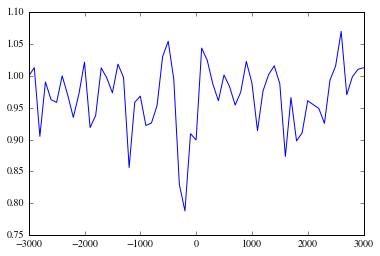

[ 0.03146753]
Model: CompoundModel265373
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Expression: [0] * [1]
Components: 
    [0]: <Const1D(amplitude=0.9732344643909389)>

    [1]: <GaussianAbsorption1D(amplitude=0.2, mean=205.0, stddev=355.0)>
Parameters:
     amplitude_0   amplitude_1     mean_1       stddev_1  
    -------------- ----------- ------------- -------------
    0.973234464391         0.0 74.0296952361 437.415768271


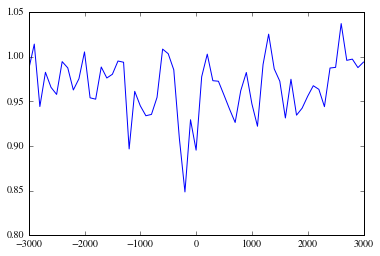

[ 0.01721766]
Model: CompoundModel265406
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Expression: [0] * [1]
Components: 
    [0]: <Const1D(amplitude=0.9758231524659803)>

    [1]: <GaussianAbsorption1D(amplitude=0.2, mean=205.0, stddev=355.0)>
Parameters:
     amplitude_0     amplitude_1       mean_1        stddev_1  
    -------------- --------------- -------------- -------------
    0.975823152466 0.0313793398347 -121.230159916 839.373809161


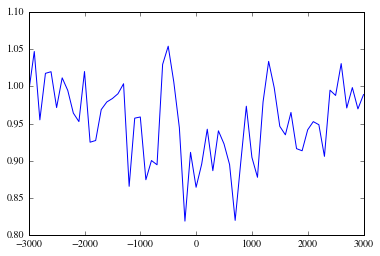

[ 0.02588835]
Model: CompoundModel265432
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Expression: [0] * [1]
Components: 
    [0]: <Const1D(amplitude=0.9730242116361104)>

    [1]: <GaussianAbsorption1D(amplitude=0.2, mean=205.0, stddev=355.0)>
Parameters:
     amplitude_0     amplitude_1       mean_1       stddev_1  
    -------------- --------------- ------------- -------------
    0.973024211636 0.0704931422355 349.288484272 799.812778132


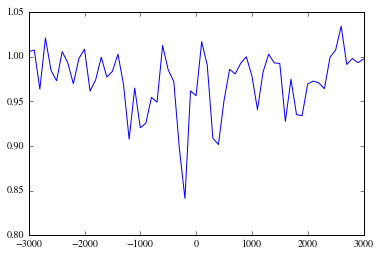

[ 0.0175256]
Model: CompoundModel265553
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Expression: [0] * [1]
Components: 
    [0]: <Const1D(amplitude=0.9847127379489548)>

    [1]: <GaussianAbsorption1D(amplitude=0.2, mean=205.0, stddev=355.0)>
Parameters:
     amplitude_0     amplitude_1       mean_1        stddev_1  
    -------------- --------------- -------------- -------------
    0.984712737949 0.0423331118569 -320.378990176 756.123658687


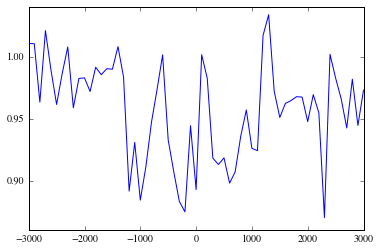

[ 0.02013219]
Model: CompoundModel265669
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Expression: [0] * [1]
Components: 
    [0]: <Const1D(amplitude=0.9743418901407419)>

    [1]: <GaussianAbsorption1D(amplitude=0.2, mean=205.0, stddev=355.0)>
Parameters:
     amplitude_0    amplitude_1       mean_1        stddev_1  
    -------------- -------------- -------------- -------------
    0.974341890141 0.055332337473 -23.7261180285 794.771310298


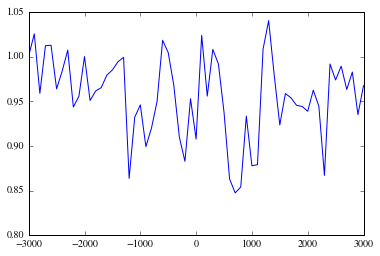

[ 0.02252976]
Model: CompoundModel265701
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Expression: [0] * [1]
Components: 
    [0]: <Const1D(amplitude=0.9682523291401504)>

    [1]: <GaussianAbsorption1D(amplitude=0.2, mean=205.0, stddev=355.0)>
Parameters:
     amplitude_0  amplitude_1     mean_1      stddev_1 
    ------------- ----------- ------------- -----------
    0.96825232914         0.0 269.054775033 540.9983816


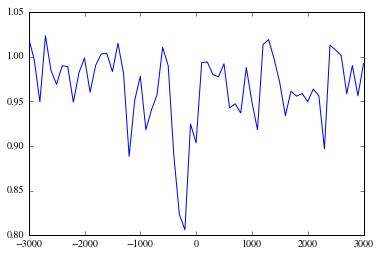

[ 0.02036479]
Model: CompoundModel265733
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Expression: [0] * [1]
Components: 
    [0]: <Const1D(amplitude=0.9784094971768994)>

    [1]: <GaussianAbsorption1D(amplitude=0.2, mean=205.0, stddev=355.0)>
Parameters:
     amplitude_0   amplitude_1     mean_1       stddev_1  
    -------------- ----------- ------------- -------------
    0.978409497177         0.0 74.4208235999 518.900760098
Equivalent width skewness: Mean=0.317357, Median=0.337117, std=0.234069 for Ntrials=1000
Centroid: Mean = 190.995, scatter=138.147
Dispersion and scatter of it:  347.048902287 111.997818492
max and min centroid:  696.455658533 -275.031393024
Wrote ../Bootstrap/Output/OIII_1334_mean.fits


In [189]:
#Mean 
reload(qpq9b)
qpq9b.boot_trans(wrest=1334.5323*u.AA,outfil='../Bootstrap/Output/OIII_1334_mean.fits',stack_tup0=stack_tup,nboot=1000)

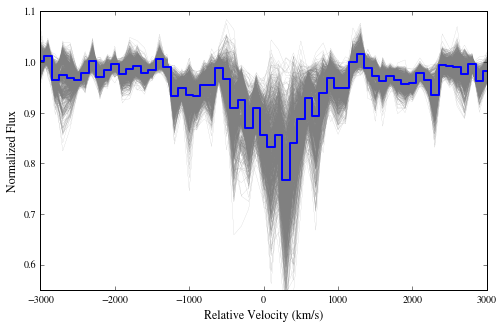

In [190]:
# plot trials
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
hdulist = fits.open('../Bootstrap/Output/OIII_1334_mean.fits')
boot_img = hdulist[1].data
for bb in np.arange(np.shape(boot_img)[0]):
    plt.plot(fin_velo,boot_img[bb,:],drawstyle='step-mid',linewidth=0.1,color='gray')
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.axis([-3000,3000,0.55,1.1])
plt.xlabel('Relative Velocity (km/s)', size=12.)
plt.ylabel('Normalized Flux', size=12.)
plt.show()

0.09017223910840932

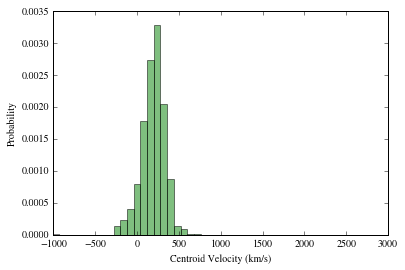

In [191]:
# Plot centroids
tau_cen = hdulist[3].data
n, bins, patches = plt.hist(tau_cen, 50, normed=1, facecolor='green', alpha=0.5,range=(-1000,3000))
plt.xlabel('Centroid Velocity (km/s)')
plt.ylabel('Probability')
len(np.where(tau_cen < 0)[0])/len(tau_cen)

In [21]:
#Median
qpq9b.boot_trans(wrest=1334.5323*u.AA,outfil='../Bootstrap/Output/OIII_1334_med.fits',stack_tup0=stack_tup,median=True)

Equivalent width skewness: Mean=0.15071, Median=0.164997, std=0.385951 for Ntrials=10000
Tau- or flux-weighted centroid: Mean = 61.1826 km / s, std=122.473 km / s
Wrote ../Bootstrap/Output/OIII_1334_med.fits


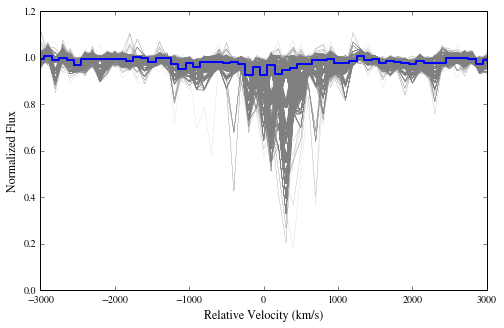

In [22]:
# plot 
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_med(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
hdulist = fits.open('../Bootstrap/Output/OIII_1334_med.fits')
boot_img = hdulist[1].data
for bb in np.arange(np.shape(boot_img)[0]):
    plt.plot(fin_velo,boot_img[bb,:],drawstyle='step-mid',linewidth=0.1,color='gray')
plt.plot(fin_velo, fin_flx_med, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity (km/s)', size=12.)
plt.ylabel('Normalized Flux', size=12.)
plt.show()

# Plot individual spectra 

In [ ]:
qpq9k.plt_qpq9(wrest=1334.5323*u.AA,S2N_cut=5.5/u.AA,stack_fg=True,zfg_mnx=(1.6,9999))

# Split in two bins of g_UV

## MgII redshift stack

In [ ]:
# Load QPQ9 data structure
enigma_path = imp.find_module('enigma')[1]
QPQ9 = xxf.bintab_to_table(enigma_path+'/data/qpq/qpq9_final.fits')
c_QPQ9 = SkyCoord(QPQ9['FG_RA']*u.deg,QPQ9['FG_DEC']*u.deg)
# Find median g_UV
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1334.5323*u.AA,S2N_cut=5.5/u.AA,zfg_mnx=(1.6,9999))
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
sv_gUV = []
for idict in all_dict:
    if idict == None:
        continue
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    sv_gUV.append(QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['G_UV'][0])
med_gUV = np.median(sv_gUV)

In [ ]:
# Mask spectra of gUV below median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1508+3635' in idict['qpq']['NAME']: #DLA not excluded by forest cut, should be excluded now
        idx_mask.append(ii) 
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    gUV = QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['G_UV'][0]
    if gUV <= med_gUV:
        idx_mask.append(ii)
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

In [ ]:
# Mask spectra of gUV above median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1508+3635' in idict['qpq']['NAME']: #DLA not excluded by forest cut, should be excluded now
        idx_mask.append(ii) 
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    gUV = QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['G_UV'][0]
    if gUV >= med_gUV:
        idx_mask.append(ii)
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

## [OIII] redshift stack

In [ ]:
# Find median g_UV
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1334.5323*u.AA,vsig_cut=50*u.km/u.s,S2N_cut=5.5/u.AA,zfg_mnx=(1.6,9999))
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
sv_gUV = []
for idict in all_dict:
    if idict == None:
        continue
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    sv_gUV.append(QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['G_UV'][0])
med_gUV = np.median(sv_gUV)

In [ ]:
# Mask spectra of gUV below median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1508+3635' in idict['qpq']['NAME']: #DLA not excluded by forest cut, should be excluded now
        idx_mask.append(ii) 
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    gUV = QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['G_UV'][0]
    if gUV <= med_gUV:
        idx_mask.append(ii)
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

In [ ]:
# Mask spectra of gUV above median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1508+3635' in idict['qpq']['NAME']: #DLA not excluded by forest cut, should be excluded now
        idx_mask.append(ii) 
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    gUV = QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['G_UV'][0]
    if gUV >= med_gUV:
        idx_mask.append(ii)
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

# Split in two bins of R_phys

## MgII redshift stack 

In [ ]:
# Find median R_phys
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1334.5323*u.AA,S2N_cut=5.5/u.AA,zfg_mnx=(1.6,9999))
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
sv_Rphys = []
for idict in all_dict:
    if idict == None:
        continue
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    sv_Rphys.append(QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['R_PHYS'][0])
med_Rphys = np.median(sv_Rphys)

In [ ]:
# Mask spectra of R_phys below median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1508+3635' in idict['qpq']['NAME']: #DLA not excluded by forest cut, should be excluded now
        idx_mask.append(ii) 
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    R_phys = QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['R_PHYS'][0]
    if R_phys <= med_Rphys:
        idx_mask.append(ii)
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

In [ ]:
# Mask spectra of R_phys above median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1508+3635' in idict['qpq']['NAME']: #DLA not excluded by forest cut, should be excluded now
        idx_mask.append(ii) 
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    R_phys = QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['R_PHYS'][0]
    if R_phys >= med_Rphys:
        idx_mask.append(ii)
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

## [OIII] redshift stack

In [ ]:
# Find median R_phys
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1334.5323*u.AA,vsig_cut=50*u.km/u.s,S2N_cut=5.5/u.AA,zfg_mnx=(1.6,9999))
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
sv_Rphys = []
for idict in all_dict:
    if idict == None:
        continue
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    sv_Rphys.append(QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['R_PHYS'][0])
med_Rphys = np.median(sv_Rphys)

In [ ]:
# Mask spectra of R_phys below median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1508+3635' in idict['qpq']['NAME']: #DLA not excluded by forest cut, should be excluded now
        idx_mask.append(ii) 
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    R_phys = QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['R_PHYS'][0]
    if R_phys <= med_Rphys:
        idx_mask.append(ii)
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

In [ ]:
# Mask spectra of R_phys above median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1508+3635' in idict['qpq']['NAME']: #DLA not excluded by forest cut, should be excluded now
        idx_mask.append(ii) 
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    R_phys = QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['R_PHYS'][0]
    if R_phys >= med_Rphys:
        idx_mask.append(ii)
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

# Split in two bins of velocity separations 

## MgII redshift stack 

In [ ]:
# Find median velocity separation 
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1334.5323*u.AA,S2N_cut=5.5/u.AA,zfg_mnx=(1.6,9999),atmosphere_cut=True)
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
sv_dv = []
for idict in all_dict:
    if idict == None:
        continue
    sv_dv.append(ltu.v_from_z(idict['qpq']['BG_Z'],idict['qpq']['Z_FG']).value)
med_dv = np.median(sv_dv)

In [ ]:
# Mask spectra of velocity separation below median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
sv_z = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1508+3635' in idict['qpq']['NAME']: #DLA not excluded by forest cut, should be excluded now
        idx_mask.append(ii) 
    dv = ltu.v_from_z(idict['qpq']['BG_Z'],idict['qpq']['Z_FG']).value
    if dv <= med_dv:
        idx_mask.append(ii)
        sv_z.append(idict['qpq']['Z_FG'])
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()
print('median z_fg of this stack =',np.median(sv_z))

In [ ]:
# Mask spectra of velocity separation above median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
sv_z = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1508+3635' in idict['qpq']['NAME']: #DLA not excluded by forest cut, should be excluded now
        idx_mask.append(ii) 
    dv = ltu.v_from_z(idict['qpq']['BG_Z'],idict['qpq']['Z_FG']).value
    if dv >= med_dv:
        idx_mask.append(ii)
        sv_z.append(idict['qpq']['Z_FG'])
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()
print('median z_fg of this stack =',np.median(sv_z))

## [OIII] redshift stack

In [ ]:
# Find median velocity separation 
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1334.5323*u.AA,vsig_cut=50*u.km/u.s,S2N_cut=5.5/u.AA,zfg_mnx=(1.6,9999))
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
sv_dv = []
for idict in all_dict:
    if idict == None:
        continue
    sv_dv.append(ltu.v_from_z(idict['qpq']['BG_Z'],idict['qpq']['Z_FG']).value)
print(sv_dv)
med_dv = np.median(sv_dv)

In [ ]:
# Mask spectra of velocity separation below median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
sv_z = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1508+3635' in idict['qpq']['NAME']: #DLA not excluded by forest cut, should be excluded now
        idx_mask.append(ii) 
    dv = ltu.v_from_z(idict['qpq']['BG_Z'],idict['qpq']['Z_FG']).value
    if dv <= med_dv:
        idx_mask.append(ii)
        sv_z.append(idict['qpq']['Z_FG'])
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()
print('median z_fg of this stack =',np.median(sv_z))

In [ ]:
# Mask spectra of velocity separation above median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
sv_z = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1508+3635' in idict['qpq']['NAME']: #DLA not excluded by forest cut, should be excluded now
        idx_mask.append(ii) 
    dv = ltu.v_from_z(idict['qpq']['BG_Z'],idict['qpq']['Z_FG']).value
    if dv >= med_dv:
        idx_mask.append(ii)
        sv_z.append(idict['qpq']['Z_FG'])
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()
print('median z_fg of this stack =',np.median(sv_z))